In [1]:
# ! conda install cuda --channel nvidia/label/cuda-12.2.0
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ! pip3 install -q datasets

In [2]:
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.1.1+cu121
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jun_13_19:42:34_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.2, V12.2.91
Build cuda_12.2.r12.2/compiler.32965470_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070


In [3]:
import os
import numpy as np

from PIL import Image
from IPython.display import display

<div class="alert alert-info">
Where to find image classification datasets ?
    
https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=trending
</div>

For this notebook, I'm using Microsoft's Cats and Dogs dataset: https://www.microsoft.com/en-us/download/details.aspx?id=54765

# Step 1 : Setting up the dataset

In a folder "data", create a subfolder for each class/label (in this case: one for "cat", and the other for "dog").

In [4]:
dataset_path = 'data/'
assert(os.path.isdir(dataset_path))
assert(dataset_path.endswith('/'))

labels = [folder for folder in os.listdir(dataset_path) if os.path.isdir(dataset_path+folder) and len(os.listdir(dataset_path+folder)) > 0]

print("Available labels:", ", ".join(labels))

Available labels: cat, dog


In [5]:
def sample_from_label(dataset_path, label, full_path=False):
    assert(os.path.isdir(dataset_path+label))
    path = dataset_path + label + '/' if full_path else ''
    return path + np.random.choice(os.listdir(dataset_path+label))

In [6]:
cat_sample_file = sample_from_label(dataset_path, 'cat', full_path=True)
dog_sample_file = sample_from_label(dataset_path, 'dog', full_path=True)

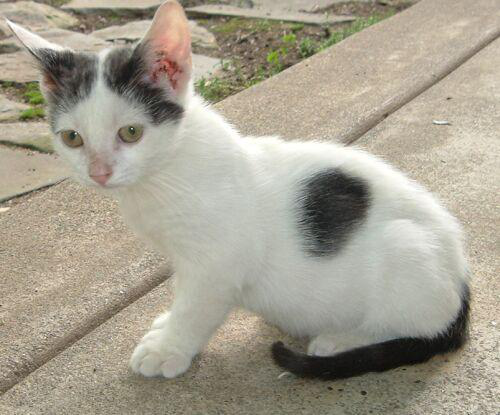

In [7]:
cat_image = Image.open(cat_sample_file)
display(cat_image)

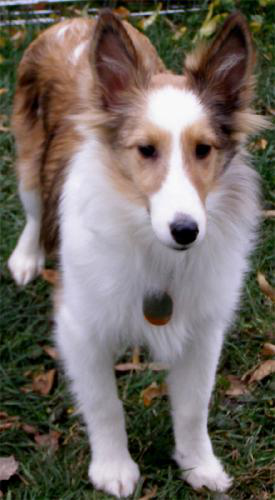

In [8]:
dog_image = Image.open(dog_sample_file)
display(dog_image)

So images in this dataset have different dimensions, which is not very good for a neural network, as we are expecting the inputs to be of the same size (width, height, depth). Therefore we will need to either crop them somehow or randomly sample a region for them.

# Step 2: Pytorch - Selecting the Model

In [23]:
import torchvision
from torchvision.models import resnet50, ResNet50_Weights, list_models
from torchvision.io import read_image

There are multiple models available for image classification which are already pretrained on big datasets, which make them suitable for smaller datasets such as the one we are using here.

PyTorch offers a selection of them in its vision module:  https://pytorch.org/vision/stable/models.htmlPyTorch 

In [24]:
classification_models = list_models(module=torchvision.models)
classification_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [25]:
weights = ResNet50_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
model = resnet50(weights=weights)
model.eval()

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
dog_img = read_image(dog_sample_file)
img.shape

torch.Size([3, 500, 275])

In [27]:
cat_img = read_image(cat_sample_file)
img.shape

torch.Size([3, 500, 275])

In [17]:
img_preprocessed = preprocess(img)
img_batch = img_preprocessed.unsqueeze(0)
img_preprocessed.shape, img_batch.shape

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [18]:
prediction = model(img_batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()

category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

collie: 59.3%


In [31]:
prediction = model(preprocess(cat_img).unsqueeze(0)).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()

category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Egyptian cat: 22.9%


In [35]:
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...


True

In [67]:
def cat_or_dog(image_path, read_image=read_image, preprocess=preprocess, model=model, class_labels=weights.meta["categories"], wn=wn):
    img = read_image(image_path)
    img_batch = preprocess(img).unsqueeze(0)
    prediction = model(img_batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    category_name = class_labels[class_id]
    category_name = category_name.lower().replace(' ', '_')

    hypernyms = [category_name]
    already_seen = set()
    while hypernyms != []:
        head_category = hypernyms.pop()
        if "cat" in head_category:
            print(head_category)
            return f"Cat! ({category_name})"
        elif "dog" in head_category:
            return f"Dog! ({category_name})"
        else:
            for synset in wn.synsets(head_category):
                for hypernym in synset.hypernyms():
                    hn = hypernym.name().split('.')[0]
                    if hn not in already_seen:
                        hypernyms.append(hn)
                        already_seen.add(hn)
            hypernyms = list(set(hypernyms))
    return "Neither cat nor dog :("

In [69]:
cat_or_dog(cat_sample_file)

egyptian_cat


'Cat! (egyptian_cat)'

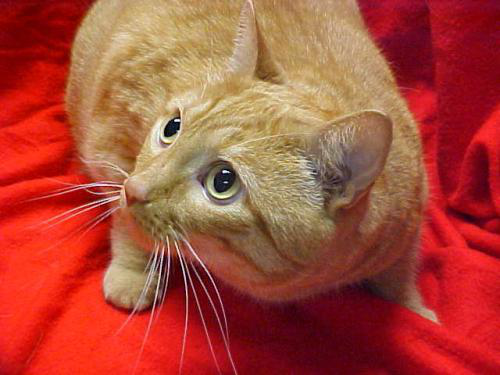

domestic_cat
Cat! (tabby)


In [72]:
cat_sample_file = sample_from_label(dataset_path, 'cat', full_path=True)
cat_image = Image.open(cat_sample_file)
display(cat_image)
print(cat_or_dog(cat_sample_file))

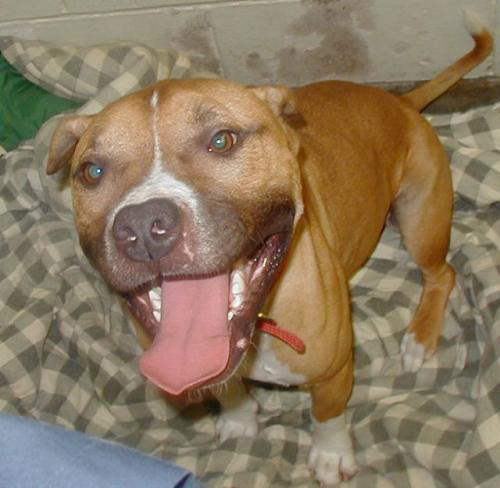

Dog! (american_staffordshire_terrier)


In [71]:
cat_sample_file = sample_from_label(dataset_path, 'dog', full_path=True)
cat_image = Image.open(cat_sample_file)
display(cat_image)
print(cat_or_dog(cat_sample_file))